In [139]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [140]:
dataset = pd.read_pickle("data/all_tickers_last_decade_features.pkl")
dataset.shape

(869435, 27)

### Exploración de serie de tiempo para GGAL (USD)
#### Tendencia
GGAL (USD) observa una tendencia que cambia de signo a partir de principios de 2018

In [141]:
ggal_5y = dataset.loc[(dataset.Year > 2015) & (dataset.Ticker == 'GGAL'),['Adj Close']]

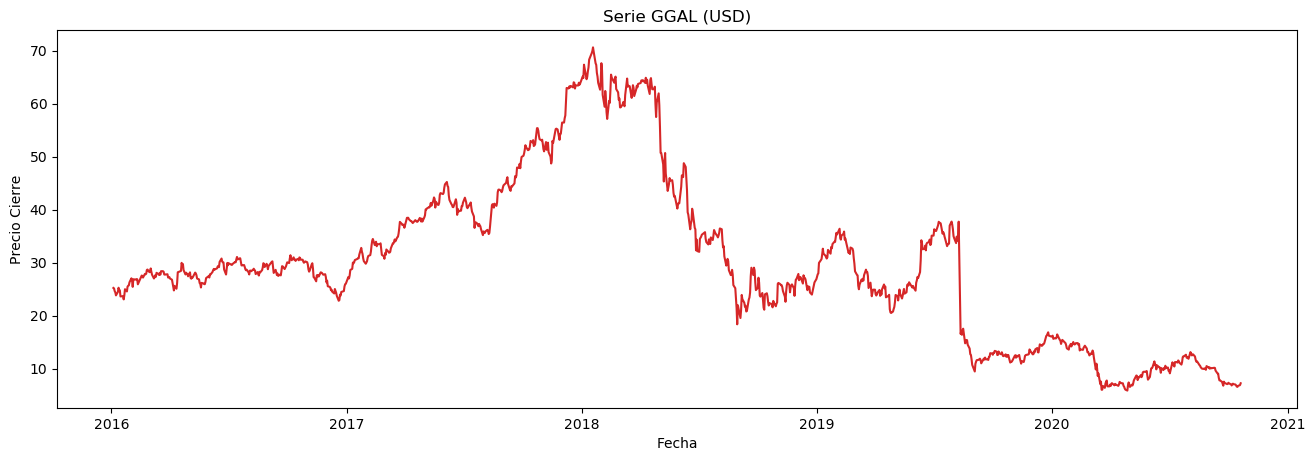

In [142]:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Precio Cierre', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(ggal_5y, x=ggal_5y.index, y=ggal_5y.loc[:,'Adj Close'], title='Serie GGAL (USD)')

#### Estacionalidad

In [143]:
# Preparamos los datos:
ggal_5y['year'] = [d.year for d in ggal_5y.index]
ggal_5y['month'] = [d.strftime('%b') for d in ggal_5y.index]
years = ggal_5y['year'].unique()

In [144]:
# ¿Cuál es el último día registrado del mes?
ggal_5y.groupby(ggal_5y.index.to_period('M')).apply(lambda x: x.index.day.max()).head(12)

Date
2016-01    29
2016-02    29
2016-03    31
2016-04    29
2016-05    31
2016-06    30
2016-07    29
2016-08    31
2016-09    30
2016-10    31
2016-11    30
2016-12    30
Freq: M, dtype: int64

In [145]:
# Precio de cierre al ultimo día registrado del mes
ggal_last = ggal_5y.iloc[ggal_5y.reset_index().groupby(ggal_5y.index.to_period('M'))['Adj Close'].idxmax()]

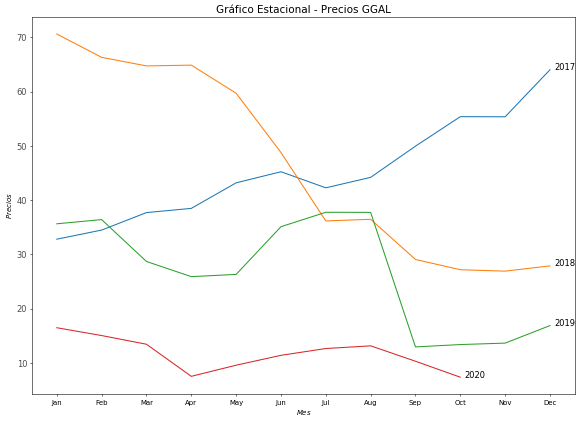

In [146]:
plt.figure(figsize=(14,10), dpi= 50)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Adj Close', data=ggal_last.loc[ggal_last.year==y, :], label=y) # grafica los 12 meses de cada año
        plt.text(ggal_last.loc[ggal_last.year==y, :].shape[0]-.9, ggal_last.loc[ggal_last.year==y, 'Adj Close'][-1:].values[0], y, fontsize=12)


plt.gca().set(ylabel='$Precios$', xlabel='$Mes$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Gráfico Estacional - Precios GGAL", fontsize=15);

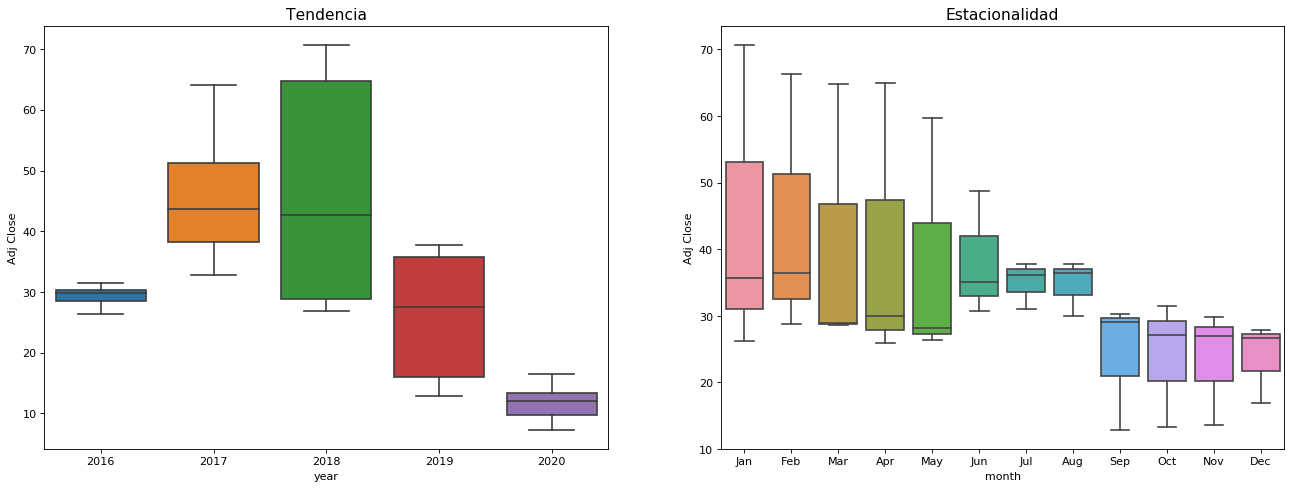

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Adj Close', data=ggal_last, ax=axes[0])
sns.boxplot(x='month', y='Adj Close', data=ggal_last.loc[~ggal_last.year.isin([2017, 2020]), :])

axes[0].set_title('Tendencia', fontsize=14); 
axes[1].set_title('Estacionalidad', fontsize=14);

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose

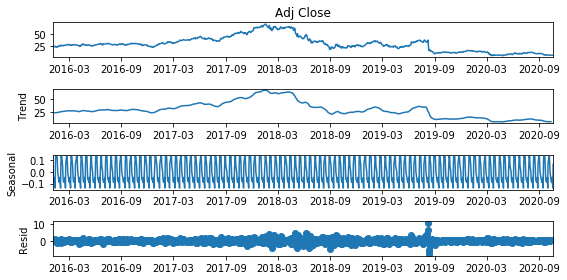

In [149]:
#from pylab import rcParams
#rcParams['figure.figsize'] = 11, 9
decomposition = seasonal_decompose(ggal_5y['Adj Close'], period=12)
decomposition.plot()
plt.show()

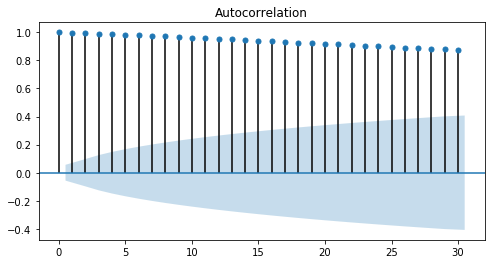

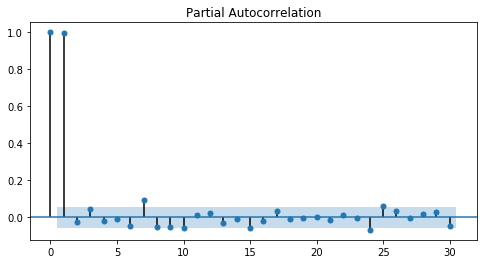

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams

rcParams['figure.figsize'] = 8, 4
plot_acf(ggal_5y['Adj Close'], lags=30)
plot_pacf(ggal_5y['Adj Close'], lags=30)
plt.show()

In [151]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(ggal_5y['Adj Close'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -1.083529
p-value                           0.721595
#Lags Used                        9.000000
Number of Observations Used    1199.000000
Critical Value (1%)              -3.435816
Critical Value (5%)              -2.863954
Critical Value (10%)             -2.568055
dtype: float64


In [152]:
# diferenciación estacional
dif_est = ggal_5y['Adj Close'].diff(12).dropna()

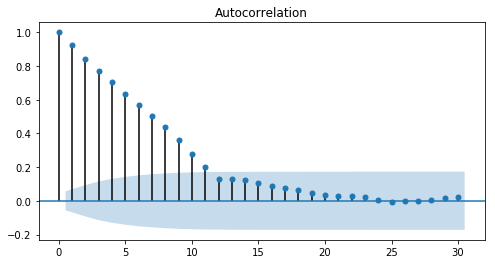

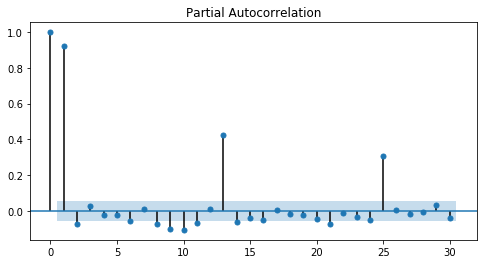

In [153]:
plot_acf(dif_est, lags=30)
plot_pacf(dif_est, lags=30)
plt.show()

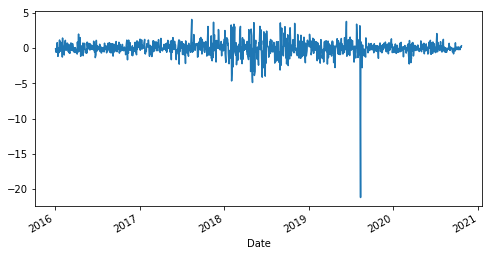

In [154]:
# diferenciación diaria
dif_day = ggal_5y['Adj Close'].diff().dropna()
ggal_5y['Adj Close'].diff().dropna().plot()

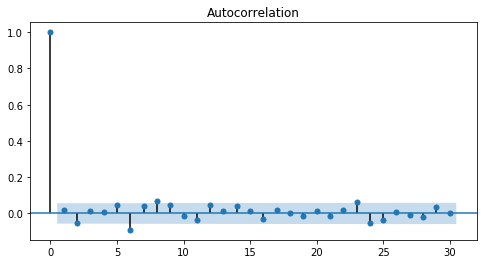

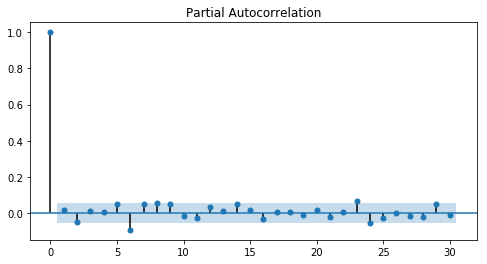

In [155]:
plot_acf(dif_day, lags=30)
plot_pacf(dif_day, lags=30)
plt.show()

In [156]:
dftest_2 = adfuller(dif_day)
print('ADF Statistic: %f' % dftest_2[0])
print('p-value: %f' % dftest_2[1])
for key, value in  dftest_2[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -10.357326
p-value: 0.000000
Valor crítico 1%: -3.44
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


### AUTO ARIMA

In [275]:
from sklearn.model_selection import train_test_split

In [276]:
ggal_train, ggal_test = train_test_split(ggal_5y, test_size=len(ggal_5y.loc[ggal_5y.index.year==2020,:]), random_state=42, shuffle=False)

In [277]:
import pmdarima as pm

modelo = pm.auto_arima(ggal_train['Adj Close'], d=1, D=1,
                      m=12, seasonal=False, 
                      max_p=3, max_q=3,trace=True, suppress_warnings=True)

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/pmdarima/arima/_validation.py:60: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3260.634, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3260.787, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3262.112, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3262.024, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3258.843, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3257.407, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3258.788, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3258.765, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3260.633, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3260.771, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3255.461, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3260.077, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3260.166, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3256.844, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]          

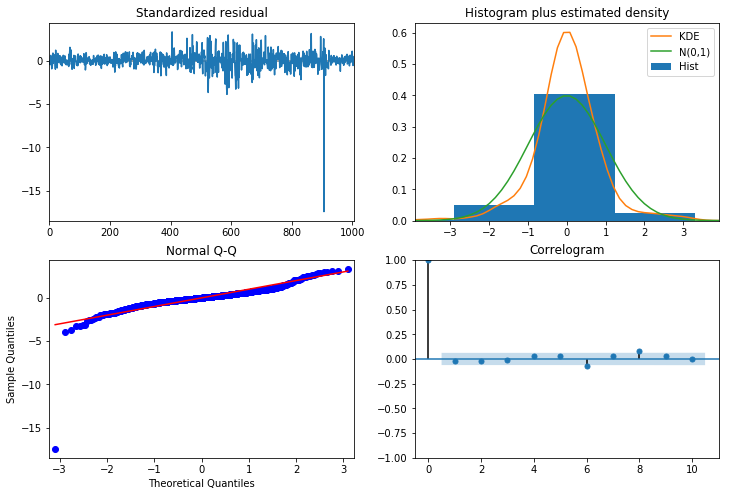

In [278]:
rcParams['figure.figsize'] = 12, 8
modelo.plot_diagnostics()
plt.show()

In [279]:
prediccion = modelo.predict(n_periods=48)
prediccion

array([15.98335812, 16.03466808, 15.99292827, 16.02688292, 15.99926138,
       16.02173105, 16.00345234, 16.01832177, 16.00622573, 16.01606566,
       16.00806104, 16.01457266, 16.00927557, 16.01358467, 16.01007929,
       16.01293086, 16.01061115, 16.01249819, 16.01096311, 16.01221187,
       16.01119603, 16.0120224 , 16.01135016, 16.01189702, 16.01145216,
       16.01181404, 16.01151966, 16.01175914, 16.01156432, 16.0117228 ,
       16.01159388, 16.01169876, 16.01161344, 16.01168284, 16.01162639,
       16.01167231, 16.01163495, 16.01166535, 16.01164062, 16.01166073,
       16.01164437, 16.01165768, 16.01164686, 16.01165566, 16.0116485 ,
       16.01165433, 16.01164959, 16.01165344])

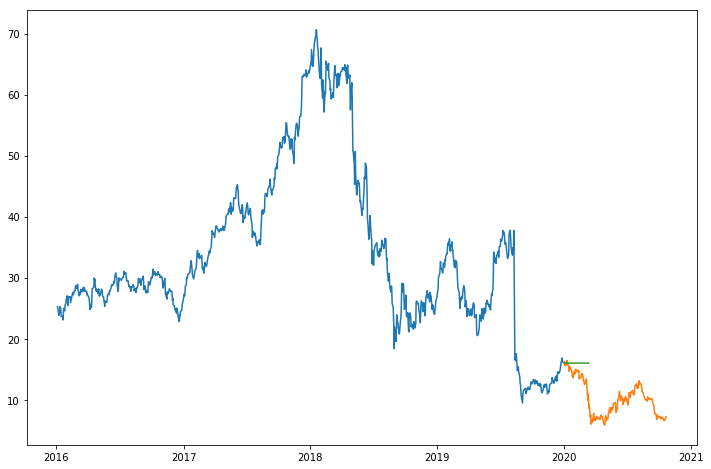

In [280]:
plt.plot(ggal_train.index, ggal_train['Adj Close'])
plt.plot(ggal_test.index, ggal_test['Adj Close'])
plt.plot(ggal_test.index[0:48], prediccion)

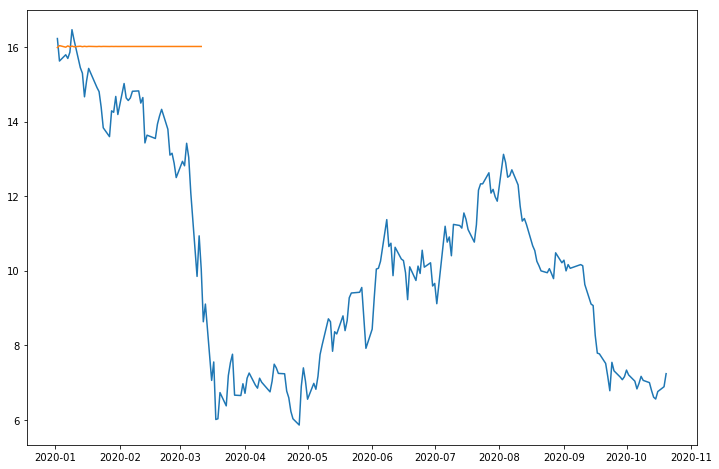

In [282]:
plt.plot(ggal_test.index, ggal_test['Adj Close'])
plt.plot(ggal_test.index[0:48], prediccion)

In [289]:
test_pred = ggal_test.iloc[0:48,].join(pd.DataFrame(prediccion, columns=['prediccion'], index=ggal_test.index[0:48]), how='left')

In [292]:
test_pred.head(20)

,Adj Close,year,month,prediccion
Date,,,,
2020-01-02,16.224398,2020,Jan,15.983358
2020-01-03,15.621297,2020,Jan,16.034668
2020-01-06,15.789374,2020,Jan,15.992928
2020-01-07,15.690505,2020,Jan,16.026883
2020-01-08,15.858583,2020,Jan,15.999261
2020-01-09,16.461683,2020,Jan,16.021731
2020-01-10,16.184851,2020,Jan,16.003452
2020-01-13,15.443333,2020,Jan,16.018322
2020-01-14,15.295030,2020,Jan,16.006226


### ARIMA

In [210]:
from statsmodels.tsa.arima_model import ARIMA

In [261]:
# uso los hiperparámetros de auto arima -> Best model:  ARIMA(1,1,1)(0,0,0)[0]

modelo_ARIMA = ARIMA(ggal_train['Adj Close'], order=(1,1,1))

resultados_ARIMA = modelo_ARIMA.fit()
resultados_ARIMA.fittedvalues.head()

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Date
2016-01-05   -0.009195
2016-01-06   -0.011017
2016-01-07   -0.019268
2016-01-08   -0.005456
2016-01-11   -0.026741
dtype: float64

In [262]:
print(resultados_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1005
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1624.762
Method:                       css-mle   S.D. of innovations              1.219
Date:                Wed, 21 Oct 2020   AIC                           3257.523
Time:                        18:24:16   BIC                           3277.174
Sample:                             1   HQIC                          3264.990
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0092      0.039     -0.236      0.814      -0.086       0.067
ar.L1.D.Adj Close    -0.9340      0.050    -18.637      0.000      -1.032      -0.836
ma.L1.D.Adj Close     0.

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


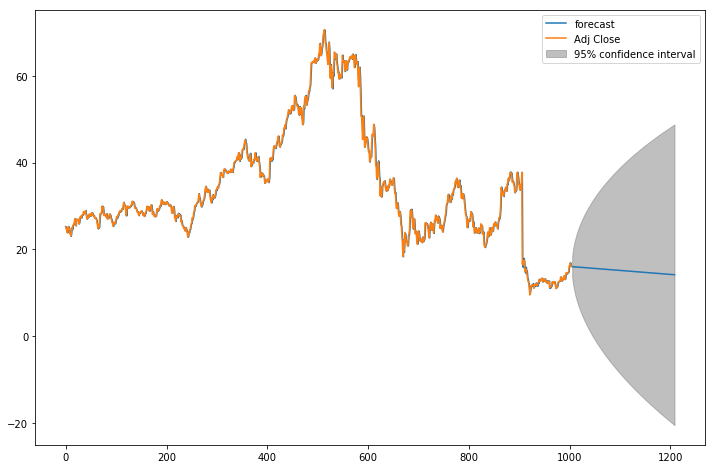

In [263]:
prediccion = resultados_ARIMA.predict(end=len(ggal_test))
resultados_ARIMA.plot_predict(end=len(ggal_5y['Adj Close']))
plt.show()